In [1]:
import time
from numpy import isnan
import numpy as np
import pandas as pd
import toolsets.feature_engineering as fe
%load_ext autoreload
%autoreload 2
import toolsets.helpers as helper
import toolsets.auto_rt_pred as ap
from mordred import Calculator, descriptors
import os
from rdkit import Chem
from tqdm import tqdm

i am updated!


In [2]:
path_to_pos = "/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/5min_obitrap_beh_pos_RHAO9U9.csv"
path_to_neg = "/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/5min_obitrap_beh_neg_RVAVEMF.csv"
path_to_lib = "/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/all_data_info-new.csv"
path_to_all_descriptors = "/Users/fanzhoukong/Documents/GitHub/LC_binbase/lcbinbase/all_unique_descriptors.csv"
# data = pd.read_csv(path_to_neg)
# data_neg = pd.read_csv()

In [5]:
# path_to_train, path_to_pred = helper.data_prep(path_to_pos, path_to_neg, path_to_lib)
path_to_train = "/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/5min_obitrap_beh_to_train.csv"

In [6]:
data_train = pd.read_csv(path_to_train)

In [7]:
data_with_descriptros = helper.get_descriptors_static(data_train['library_smiles'], path_to_all_descriptors)

100%|██████████| 151/151 [00:01<00:00, 108.01it/s]


In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

In [9]:
imputer = IterativeImputer(estimator=RandomForestRegressor(n_jobs = -1), n_nearest_features=None, imputation_order='ascending')

In [37]:
x = data_with_descriptros.drop(['smiles'], axis=1)

In [27]:
corr_matrix = x.corr().abs()


In [32]:
corr_matrix['MATS8i']

ABC          0.235842
ABCGG        0.258363
nAcid        0.076812
nBase        0.097936
nAromAtom    0.158068
               ...   
AMID_O       0.101624
MID_X        0.067671
AMID_X       0.072194
Vabc         0.202192
mZagreb1     0.193410
Name: MATS8i, Length: 1476, dtype: float64

In [29]:
upper = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))

In [31]:
x.shape

(151, 560)

In [23]:
x['MATS8i']

KeyError: 'MATS8i'

In [24]:
x.shape

(151, 791)

In [22]:
x.isnull().any().sum()

115

In [ ]:
imputer.fit(x)
x_imputed = imputer.transform(x)

In [13]:
data_with_descriptros.reset_index(inplace=True, drop=True)

In [16]:
data_with_descriptros.insert(1, "retention_time", data_train['rt'])
data_with_descriptros.insert(2, "method", data_train['method'])

In [18]:
data_with_descriptros.head()

,smiles,retention_time,method,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,...,MID_C,AMID_C,MID_N,AMID_N,MID_O,AMID_O,MID_X,AMID_X,Vabc,mZagreb1
0,CCC(C(=O)N)N1CCCC1=O,0.293,5min_obitrap_beh_pos_RHAO9U9,8.692130,9.097384,0,0,0,0,26,...,15.809979,1.317498,3.874799,0.322900,3.459294,0.288274,0.0,0.0,168.86894,5.444445
1,CCCCC(=O)N(CC1=CC=C(C=C1)C2=CC=CC=C2C3=NNN=N3)...,0.335,5min_obitrap_beh_pos_RHAO9U9,24.305499,20.006308,3,0,17,17,61,...,48.929510,1.529047,10.258434,0.320576,5.182271,0.161946,0.0,0.0,408.88060,11.111111
2,C(CC(C(=O)O)N)CNC(=O)N,2.163,5min_obitrap_beh_pos_RHAO9U9,8.284683,8.139582,1,1,0,0,25,...,11.904636,0.992053,5.355958,0.446330,5.060316,0.421693,0.0,0.0,166.42041,6.333334
3,CC(C)C(C(=O)O)NC(=O)C(CC1=CC=C(C=C1)O)N,1.682,5min_obitrap_beh_pos_RHAO9U9,14.786544,13.363246,1,1,6,6,40,...,28.052740,1.402637,3.745050,0.187252,6.911197,0.345560,0.0,0.0,271.41592,9.277778
4,CN(CCOC1=CC=C(C=C1)CC2C(=O)NC(=O)S2)C3=CC=CC=N3,0.244,5min_obitrap_beh_pos_RHAO9U9,19.339172,14.705888,0,0,12,12,44,...,37.132950,1.485318,6.125851,0.245034,5.559553,0.222382,0.0,0.0,317.79312,7.527778


In [11]:
data_train['method'].value_counts()

5min_obitrap_beh_pos_RHAO9U9    122
5min_obitrap_beh_neg_RVAVEMF     29
Name: method, dtype: int64

In [21]:
data_with_descriptros.isnull().sum()

smiles            0
retention_time    0
method            0
ABC               0
ABCGG             0
                 ..
AMID_O            0
MID_X             0
AMID_X            0
Vabc              0
mZagreb1          0
Length: 1479, dtype: int64

In [19]:
data_confirmed = fe.mislable_exclusion(data_with_descriptros, 'method',data_with_descriptros.drop(['method', 'retention_time','smiles'], axis=1).columns, 0.16)

k-fold:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [14]:
train, test = helper.make_train_test_by_compound(data_confirmed)

In [625]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [139]:
filename = "data/test/0-60.csv"
output_path = (filename.split("/")[:-1])

output_filename = filename.split("/")[-1].split('.')[0]+"_with_descriptor.csv"
output_path.extend([output_filename])
output = "/".join(output_path)
# (output_filename.extend(["_".join((filename.split('/')[-1].split("_"))[0:-2])+"_with_descriptor.csv"]))
# "/".join(output_filename)
# output_filename.extend([("_".join(filename.split('/')[-1].split(".")[0])+"_with_descriptor.csv")])

In [140]:
output

'data/test/0-60_with_descriptor.csv'

In [114]:
output_filename = "/".join(filename.split("/")[:-1])

In [116]:
output_filename = (filename.split("/")[-1])

In [119]:
output_filename.split('.')[0]

'0-60'

In [75]:
output_filename.extend(filename.split('/')[-1].split(".")[0]+"_with_descriptor.csv")

In [626]:
model = TabularPredictor.load("model/demo_by_compound")

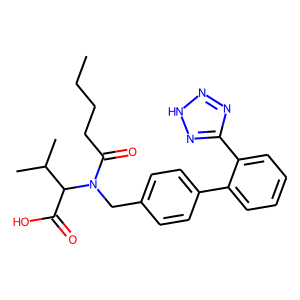

In [689]:
# data_with_des.loc[data_with_des['library_smiles'].isin(['CCCCC(=O)N(CC1=CC=C(C=C1)C2=CC=CC=C2C3=NNN=N3)C(C(C)C)C(=O)O','CCC(C(=O)N)N1CCCC1=O'])]['SLogP']
# from mordred import Calculator, descriptors
# helper.draw_molecule('CCCCC(=O)N(CC1=CC=C(C=C1)C2=CC=CC=C2C3=NNN=N3)C(C(C)C)C(=O)O')
# helper.draw_molecule('CCC(C(=O)N)N1CCCC1=O')

'/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/5min_obitrap_beh_with_descriptor.csv'

In [2]:
data_columns = pd.read_csv("~/Documents/GitHub/LC_binbase/5min_obitrap_beh/Feature_column.csv")

In [3]:
data_columns.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.786544,13.363246,1,1,23.825797,2.288877,4.577753,23.825797,1.19129,3.873971,...,9.561772,52.736952,280.142307,7.003558,901,27,94.0,104.0,9.277778,4.5


In [4]:
additional_pred = pd.read_csv("~/Documents/GitHub/LC_binbase/5min_obitrap_beh/CORE_pos_and negHILIC_mzrt_5min method_07-2022 for Fanzhou.csv")

In [7]:
additional_pred=additional_pred[~additional_pred['smiles'].isnull()]

In [9]:
addi_pred = helper.make_single_prediction(additional_pred['smiles'], "model/nist_68/", data_columns.columns)

there are 1389 unique smiles needs to be calculated
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
i am in true1!!!
the time used is 21.059  min


In [11]:
addi_pred.reset_index(inplace=True, drop=True)

In [12]:
additional_pred['predicted_rt']=addi_pred

In [14]:
additional_pred.to_csv("~/Documents/GitHub/LC_binbase/5min_obitrap_beh/CORE_pos_and negHILIC_mzrt_5min method_07-2022 for Fanzhou_with_pred.csv", index = False)